# Shaw 2023
This looks at high percentiles of upper troposphere (200hPa) zonal wind, to see how they vary with warming. Shaw 2023 indicated that the fastest winds increase the most.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-12-12 11:53:25,708 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [5]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 200           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all pressure levels, so can do thermal wind calculation
        ds_use = ds[i].sel(pfull=slice(pressure_ft, np.inf)).sel(time=slice(use_time_start, np.inf))    
        ds_use = ds_use.isel(pfull=slice(None, None, -1))       # make surface pressure the first index
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


In [6]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'midlat'
lat_min = 20
lat_max = 60
# Poles
# region = 'highlat'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

In [7]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

take_abs_u = True       # whether to consider speed or velocity of winds
u_func = lambda x: np.abs(x) if take_abs_u else lambda x: x

temp_mean = np.zeros((n_exp, n_lat))
u_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of u percentile
u_quant2 = np.zeros((n_exp, n_lat, n_quant))
# upper troposphere zonal wind as function of temperature percentile
u_quant3 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp[0].mean(dim='lon_time')       # surface temp
        temp_quant2[i] = ds_all[i].temp[0].quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
        
        u_mean[i] = u_func(ds_all[i].ucomp[-1]).mean(dim='lon_time')        # free trop u
        u_quant2[i] = u_func(ds_all[i].ucomp[-1]).quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                u_quant3[i, k, j] = u_func(ds_all[i].ucomp[-1, k, use_ind]).mean()                    
                pbar.update(1)

100%|██████████| 5940/5940 [00:48<00:00, 121.82it/s]


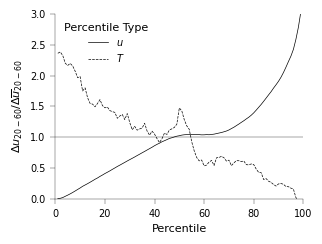

In [8]:
save_u_sf_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(((u_quant2[1] - u_quant2[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
        color='k', label='$u$')
ax.plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
        color='k', linestyle='--', label='$T$')
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.set_xlim(0, 100)
ax.set_ylim(0, 3)
ax.set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax.set_xlabel('Percentile')
ax.legend(title='Percentile Type', loc='upper left')

if save_fig or save_u_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [9]:
u_temp_percentile = np.zeros((n_exp, n_lat, n_quant))              # percentile of u corresponding to each percentile of near-surface temp
with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j in range(n_quant):
                u_temp_percentile[i, k, j] = percentileofscore(ds_all[0].ucomp[-1, k], u_quant3[i, k, j])
                pbar.update(1)

100%|██████████| 5940/5940 [00:01<00:00, 3089.79it/s]


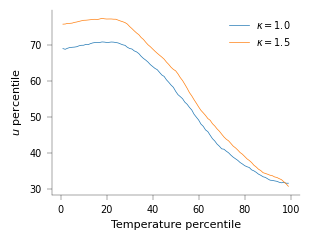

In [10]:
save_u_percentile_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(quant_plot, np.average(u_temp_percentile[i, lat_use], axis=0, weights=lat_weights_use), color=default_colors[i],
            label='$\kappa={:.1f}$'.format(tau_lw[i]))
ax.legend()
ax.set_xlabel('Temperature percentile')
ax.set_ylabel('$u$ percentile')

if save_fig or save_u_percentile_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_percentile_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [11]:
quant2_lat_use = 99
quant3_lat_use = 1
u_quant2_lat = np.zeros((n_exp, n_lat))
u_quant3_lat = np.zeros((n_exp, n_lat))
temp_global_mean = np.zeros(n_exp)

with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_global_mean[i] = area_weighting(ds_all[i].temp[0]).mean()
        u_quant2_lat[i] = u_func(ds_all[i].ucomp[-1]).quantile(quant2_lat_use/100, dim='lon_time', keep_attrs=True)
        for k in range(n_lat):
            use_ind = get_quant_ind(ds_all[i].temp[0, k], quant3_lat_use, 0.5, 0.5)
            u_quant3_lat[i, k] = u_func(ds_all[i].ucomp[-1, k, use_ind]).mean()                    
            pbar.update(1)

100%|██████████| 128/128 [00:01<00:00, 81.47it/s] 


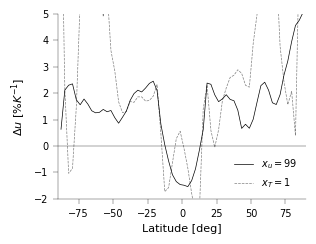

In [12]:
save_u_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds_all[0].lat, 100*(u_quant2_lat[1]-u_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant2_lat[0], color='k',
        label=f'$x_u={quant2_lat_use}$')
ax.plot(ds_all[0].lat, 100*(u_quant3_lat[1]-u_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant3_lat[0], color='k',
        linestyle='--', alpha=0.5, label=f'$x_T={quant3_lat_use}$')
ax.hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax.set_xlim(-90, 90)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$\Delta u$ [$\%K^{-1}$]')
ax.legend()
ax.set_ylim(-2, 5)

if save_fig or save_u_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [23]:
def get_u_thermal(ds):
    pressure = ds.pfull.to_numpy() * 100
    f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(ds_all[0].lat).to_numpy())
    integrand = np.gradient(ds.temp, np.deg2rad(ds.lat), axis=1)/pressure[:, np.newaxis, np.newaxis]
    return scipy.integrate.simpson(integrand, pressure, axis=0) * R/(radius_earth * f_coriolis[:, np.newaxis])

In [32]:
u_thermal = np.asarray([get_u_thermal(ds_all[i]) for i in range(n_exp)])

In [70]:
u_thermal_mean = np.zeros((n_exp, n_lat))
u_thermal_quant2 = np.zeros((n_exp, n_lat, n_quant))
u_thermal_quant3 = np.zeros((n_exp, n_lat, n_quant))

with tqdm(total=n_exp*n_quant*len(lat_use), position=0, leave=True) as pbar:
    for i in range(n_exp):
        u_thermal_mean[i] = np.mean(u_func(ds_all[i].ucomp[-1]), axis=1)
        u_thermal_quant2[i] = np.quantile(u_func(u_thermal[i]), quant_plot/100, axis=-1).transpose()
        for k in range(n_lat):
            if k not in lat_use:
                continue
            for j, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_all[i].temp[0, k], quant, 0.5, 0.5)
                u_thermal_quant3[i, k, j] = u_func(u_thermal[i, k, use_ind]).mean()                    
                pbar.update(1)
                
u_thermal_quant2_lat = np.zeros((n_exp, n_lat))
u_thermal_quant3_lat = np.zeros((n_exp, n_lat))

with tqdm(total=n_exp*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        u_thermal_quant2_lat[i] = np.quantile(u_func(u_thermal[i]), quant2_lat_use/100, axis=-1)
        for k in range(n_lat):
            use_ind = get_quant_ind(ds_all[i].temp[0, k], quant3_lat_use, 0.5, 0.5)
            u_thermal_quant3_lat[i, k] = u_func(u_thermal[i, k, use_ind]).mean()                     
            pbar.update(1)

100%|██████████| 128/128 [00:01<00:00, 81.53it/s] 


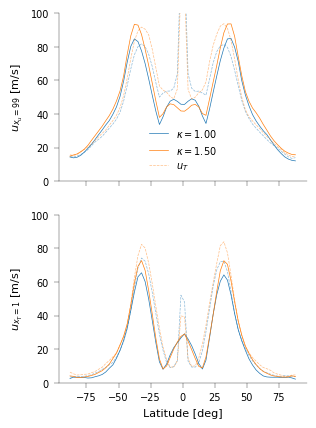

In [62]:
save_u_thermal_lat_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[0].plot(ds_all[0].lat, u_quant2_lat[i], color=default_colors[i], label='$\kappa={:.2f}$'.format(tau_lw[i]))
    ax[0].plot(ds_all[0].lat, u_thermal_quant2_lat[i], color=default_colors[i], linestyle='--', alpha=0.5, label='$u_T$' if i==1 else None)
    ax[1].plot(ds_all[0].lat, u_quant3_lat[i], color=default_colors[i])
    ax[1].plot(ds_all[0].lat, u_thermal_quant3_lat[i], color=default_colors[i], linestyle='--', alpha=0.5)
ax[0].set_ylim(0, 100)
ax[0].legend()
ax[0].set_ylabel('$u_{x_u=99}$ [m/s]')
ax[1].set_ylabel('$u_{x_T=1}}$ [m/s]')
ax[-1].set_xlabel('Latitude [deg]')
if save_fig or save_u_thermal_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_thermal_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

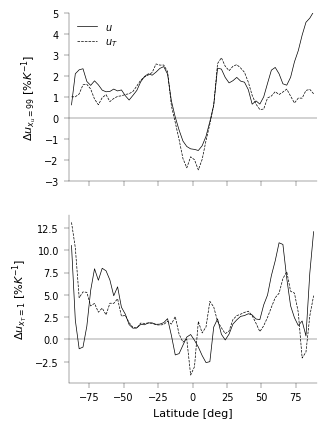

In [69]:
save_delta_u_thermal_lat_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True)
ax[0].plot(ds_all[0].lat, 100*(u_quant2_lat[1]-u_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant2_lat[0], color='k',
        label='$u$')
ax[0].plot(ds_all[0].lat, 100*(u_thermal_quant2_lat[1]-u_thermal_quant2_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_thermal_quant2_lat[0], color='k', label='$u_T$', linestyle='--')

ax[1].plot(ds_all[0].lat, 100*(u_quant3_lat[1]-u_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_quant3_lat[0], color='k')
ax[1].plot(ds_all[0].lat, 100*(u_thermal_quant3_lat[1]-u_thermal_quant3_lat[0])/(temp_global_mean[1]-temp_global_mean[0])/u_thermal_quant3_lat[0], color='k', linestyle='--')

ax[0].hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax[1].hlines(0,-90,90, color='k', linewidth=ax_linewidth)
ax[0].set_xlim(-90, 90)
ax[-1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$\Delta u_{x_u=99}$ [$\%K^{-1}$]')
ax[1].set_ylabel('$\Delta u_{x_T=1}$ [$\%K^{-1}$]')
ax[0].legend()
ax[0].set_ylim(-3, 5)

if save_fig or save_delta_u_thermal_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_delta_thermal_lat_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

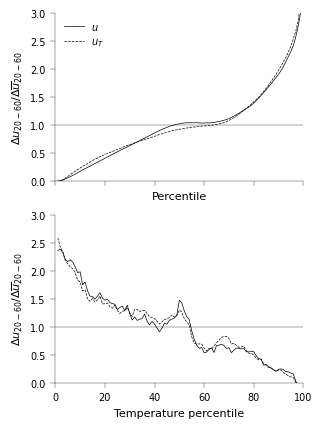

In [80]:
save_u_thermal_sf_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2 * width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(((u_quant2[1] - u_quant2[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
           color='k', label='$u$')
ax[0].plot(quant_plot, np.average(((u_thermal_quant2[1] - u_thermal_quant2[0])/(u_thermal_mean[1]-u_thermal_mean[0])[:, np.newaxis])[lat_use],
                                  axis=0, weights=lat_weights_use), color='k', label='$u_T$', linestyle='--')

ax[1].plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
           color='k')
ax[1].plot(quant_plot, np.average(((u_thermal_quant3[1] - u_thermal_quant3[0])/(u_thermal_mean[1]-u_thermal_mean[0])[:, np.newaxis])[lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle='--')
# ax.plot(quant_plot, np.average(((u_quant3[1] - u_quant3[0])/(u_mean[1]-u_mean[0])[:, np.newaxis])[lat_use], axis=0, weights=lat_weights_use),
#         color='k', linestyle='--', label='$T$')
ax[0].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[1].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 3)
ax[0].set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax[1].set_ylabel('$\Delta u_{20-60}/\Delta \overline{u}_{20-60}$')
ax[0].set_xlabel('Percentile')
ax[1].set_xlabel('Temperature percentile')
ax[0].legend(loc='upper left')

if save_fig or save_u_thermal_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/u_thermal_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\lambda$ Decompostion
### Combine latitudes
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the mean day.

Note the black line below differs from actual $\lambda$ because here I am plotting it as a function of near-surface temperature percentile, whereas for lambda plot in `surface/single_kappa` notebook, I plot it as a function of near-surface MSE percentile. I.e. the x-axis are different.

In [6]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

In [7]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

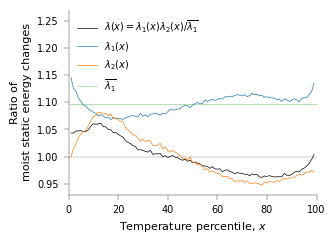

In [20]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3[lat_use], axis=0, weights=lat_weights_use), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0.93, 1.27)
ax.set_xlabel(f"{'Temperature percentile' if quant3_method=='temp' else 'Moist static energy percentile'}, $x$")
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### High percentiles as function of latitude
In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.

In [9]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

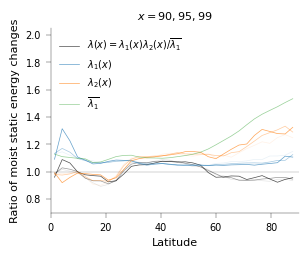

In [10]:
quant_subset = [90,95,99]
# quant_subset = [10,5,1]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
quant_subset_alpha = [0.1+i*(0.9/len(quant_subset)) for i in range(len(quant_subset))]
lat_plot = ds_all[0].lat[int(n_lat/2):]

save_lambda_decomp_lat_fig = False
fig_lambda_decomp, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels[i])
ax.plot(lat_plot, abs_lat_av(lambda_3), color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title('$x=90, 95, 99$')
# ax.set_title('$x=10, 5, 1$')
ax.set_ylim(0.7,2.05)
if (save_fig or save_lambda_decomp_lat_fig):
    fig_lambda_decomp.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda_2$ Decomposition
$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$ can be split up into a product of two terms:
$$\lambda_2(x) = \frac{c_p+L_v\alpha(T_{FT}(x))q^*(T_{FT}(x))}{c_p+L_v\alpha(\overline{T_{FT}})q^*(\overline{T_{FT}})} \times
\frac{\delta T_{FT}(x)}{\delta \overline{T_{FT}}$$
The first term being just evaluated at the historical simulation, and the second incorporating temperature changes. This equation assumes no changes to the geopotential height term, but in zhang 2023, these can be related to temperature as well.
I label these contributions as $\lambda_{2_0}$ and $\lambda_{2_{\delta}}$ respectively.

The black and blue lines below differ, indicating that the geopotential height or potentialy squared temperature, $\delta T^2$ terms may be important.

In [11]:
lambda_2_0 = (c_p + L_v * clausius_clapeyron_factor(temp_quant3[0, 1], pressure_ft_actual) *
              sphum_sat(temp_quant3[0, 1], pressure_ft_actual)) / np.expand_dims(
    c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual), axis=-1)
# lambda_2_0 = lambda_2_0 + np.expand_dims((9.81*ds_all[0].height[1].mean(dim='lon_time')/temp_mean[0, 1]) / (c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
# lambda_z = temp_quant3[0, 1]*9.81*np.expand_dims(ds_all[0].height[1].mean(dim='lon_time'), axis=-1)/np.expand_dims(temp_mean[0, 1]**2*(c_p + L_v * clausius_clapeyron_factor(temp_mean[0, 1], pressure_ft_actual) * sphum_sat(temp_mean[0, 1], pressure_ft_actual)), axis=-1)
lambda_2_delta = (temp_quant3[1]-temp_quant3[0])[1]/np.expand_dims(temp_mean[1]-temp_mean[0], axis=-1)[1]

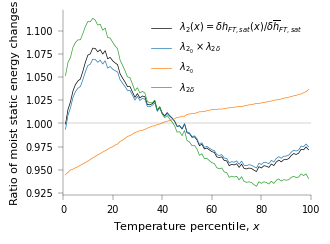

In [12]:
save_lambda2_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels_lambda2 = ['$\lambda_2(x) = \delta h_{FT, sat}(x) / \delta \overline{h}_{FT, sat}$',
                  '$\lambda_{2_0} \\times \lambda_{2\delta}$', '$\lambda_{2_0}$', '$\lambda_{2\delta}$']
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color=use_color, label=labels_lambda2[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(1, 0, 100, color='k', alpha=0.5, lw=ax_linewidth)
ax.legend()
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
if save_fig or save_lambda2_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

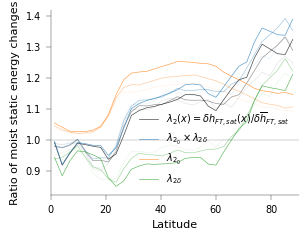

In [13]:
save_lambda2_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_2, lambda_2_0 * lambda_2_delta, lambda_2_0, lambda_2_delta]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=quant_subset_alpha[0], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=quant_subset_alpha[1], color=use_color)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=quant_subset_alpha[2], color=use_color, label=labels_lambda2[i])
ax.hlines(1, -90, 90, color='k', alpha=0.5, lw=ax_linewidth)
ax.set_xlim(0, 90)
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Ratio of moist static energy changes')
if (save_fig or save_lambda2_decomp_lat_fig):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_decomp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

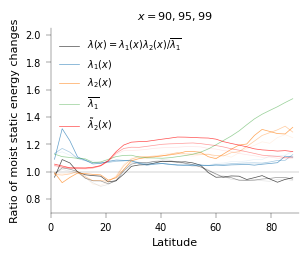

In [14]:
save_lambda_decomp_lat_fig2 = True
fig = copy.deepcopy(fig_lambda_decomp)
ax = fig.gca()
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av(lambda_2_0[:, quant_subset_ind[i]]), color='r', 
            label='$\\tilde{\lambda}_2(x)$' if i==len(quant_subset)-1 else None, alpha=quant_subset_alpha[i] )
ax.legend()
if (save_fig or save_lambda_decomp_lat_fig2):
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat2_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, pad_inches=save_pad_inches)
fig

### Add $\lambda_{2_0}$ to theory
The orange line in the theory below assumes that $\lambda_1 = \lambda_3$ and $\lambda_2 = \lambda_{2_0}$. These combine to give $\lambda = \lambda_{2_0}$ rather than $\lambda=1$.

This seems to improve things at higher latitudes but only because the $\lambda_1 = \lambda_3$ approximation breaks down in the opposite way so you get cancellation of errors.
I.e. we assume that $\lambda_3 \approx \lambda_1$ and $\lambda_2 \approx \lambda_{2_0}$. When actually at high latitudes, $\lambda_3 > \lambda_1$ and $\lambda_2 > \lambda_{2_0}$. Because $\lambda = \lambda_1 \lambda_2 / \lambda_3$, if we underestimate both $\lambda_3$ and $\lambda_2$, then these effects offset each other.

In [15]:
# Obtain surface quantities required for theories
sphum_mean = np.zeros((n_exp, n_lat))
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in tqdm(range(n_exp)):
    ds_use = ds_all[i].sel(pfull=p_surface/100)
    sphum_mean[i] = ds_use.sphum.mean(dim='lon_time')
    temp_quant2[i] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_use.sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'lambda_2']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, 0, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=False, delta_mse_ratio=lambda_2_0[i:i+1] if 'lambda' in method else None,
                                        taylor_level='linear_rh_diff')
delta_mse_ratio = (mse_quant2[1]-mse_quant2[0])/np.expand_dims((mse_mean[1]-mse_mean[0])[0], axis=-1)

100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


In [16]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too

av_quant_ind = np.where(quant_plot==50)[0]
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = [int(np.round(scipy.stats.percentileofscore(ds_all[0].temp[0][i], float(ds_all[0].temp[0][i].mean())))) 
                    for i in range(n_lat)]
else:
    av_quant_ind = [50]*n_lat
av_quant_ind = numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind))
av_quant_flat_ind = np.ravel_multi_index((np.arange(n_lat), av_quant_ind), temp_quant2[0].shape)
sf_denom = {key: temp_diff_theory[key].flatten()[av_quant_flat_ind] for key in temp_diff_theory.keys()}
if scaling_factor_av == 'mean':
    sf_denom['simulated'] = temp_mean[1, 0]-temp_mean[0, 0]
else:
    sf_denom['simulated'] = (temp_quant2[1]-temp_quant2[0]).flatten()[av_quant_flat_ind]
for key in sf_denom:
    sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)
    
if scaling_factor_av_type == 'simulated':
    for key in temp_diff_theory.keys():
        # Set all theoretical mean/median predictions to the simulated
        sf_denom[key] = sf_denom['simulated'] 

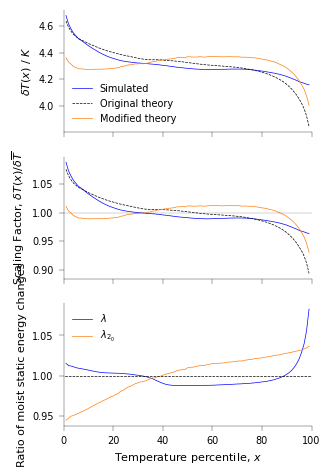

In [17]:
save_lambda2_theory_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 0.75*3*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])[lat_use], axis=0, weights=lat_weights_use), 
           label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
           label='Original theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use], axis=0, weights=lat_weights_use), color=default_colors[1],
           label='Modified theory')
ax[1].plot(quant_plot, 
           np.average((temp_quant2[1]-temp_quant2[0])[lat_use]/sf_denom['simulated'][lat_use],
                                  axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use]/sf_denom['linear'][lat_use], 
                                  axis=0, weights=lat_weights_use), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['lambda_2'][lat_use]/sf_denom['lambda_2'][lat_use], 
                                  axis=0, weights=lat_weights_use), color=default_colors[1])
# Add lambda comparison
for i, var in enumerate([delta_mse_ratio, lambda_2_0]):
    ax[2].plot(quant_plot, np.average(var[lat_use], axis=0, weights=lat_weights_use),
            color='b' if i == 0 else default_colors[1], label='$\lambda$' if i==0 else '$\lambda_{2_0}$')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=ax_linewidth)
ax[2].hlines(1, -10, 100, linestyles='--', color='k')
ax[2].set_ylabel('Ratio of moist static energy changes')
ax[2].legend()
ax[0].legend()
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[0].set_ylim(4,12)
# ax[1].set_ylim(0.55,1.6)
# ax[2].set_ylim(0.75,1.5)

if save_fig or save_lambda2_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_lambda2_theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

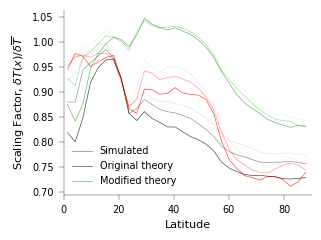

In [18]:
save_theory_lambda2_lat_fig = False
norm_by_sf = True
if norm_by_sf:
    denom = {key: sf_denom[key].flatten() for key in sf_denom}
else:
    denom = {key: 1 for key in sf_denom}
include_theory = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av((temp_quant2[1, :, quant_subset_ind[i]]-temp_quant2[0, :, quant_subset_ind[i]])/
                                 denom['simulated']), color='r', alpha=quant_subset_alpha[i],
            label='Simulated' if i==2 else None)
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['linear'][:, quant_subset_ind[i]]/
                                     denom['linear']), color='k', alpha=quant_subset_alpha[i],
                label='Original theory' if i==2 else None)
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory['lambda_2'][:, quant_subset_ind[i]]/
                         denom['lambda_2']), color=default_colors[2], alpha=quant_subset_alpha[i],
        label='Modified theory' if i==2 else None)
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax.set_xlabel('Latitude')
if include_theory:
    ax.legend(frameon=False)
ax.set_xlim(0,90)
# ax.set_ylim(0.4, 1.05)
if (save_fig or save_theory_lambda2_lat_fig):
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/temp_theory_lambda2_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)